In [22]:
import os
import json
import warnings
import numpy as np
import xarray as xr
import proplot as pplt
warnings.filterwarnings('ignore')
pplt.rc.update({'figure.dpi':100,'reso':'xx-hi'})

In [23]:
with open('/global/cfs/cdirs/m4334/sferrett/monsoon-discovery/scripts/configs.json','r',encoding='utf-8') as f:
    CONFIGS = json.load(f)
SPLITSDIR  = CONFIGS['filepaths']['splits']      
MODELDIR   = CONFIGS['filepaths']['models']    
PREDSDIR   = CONFIGS['filepaths']['predictions']  
MODELS     = CONFIGS['models']
SPLIT      = 'valid'
PRTHRESH   = 0.01
LANDTHRESH = 0.5
landfrac   = xr.open_dataarray('/global/cfs/cdirs/m4334/sferrett/monsoon-discovery/data/interim/lf.nc')

In [24]:
with xr.open_dataset(os.path.join(SPLITSDIR,f'{SPLIT}.h5'),engine='h5netcdf') as ds:
    truepr = ds.pr.load()
    
results = []
for name,run in MODELS['pod']['runs'].items():
    filepath  = os.path.join(PREDSDIR,f'{name}_{SPLIT}_pr.nc')
    if not os.path.exists(filepath):
        continue
    with xr.open_dataset(filepath) as ds:
        ypred = ds.pr.load()
    ytrue,ypred = xr.align(truepr,ypred,join='inner')
    results.append((name,ytrue,ypred))

print(f'Found {len(results)} models with predictions!')

Found 2 models with predictions!


In [25]:
def get_r2(ytrue,ypred,dims=None,landfrac=None,landthresh=LANDTHRESH):
    dims = list(ytrue.dims) if dims is None else dims
    if landfrac is not None:
        r2values = []
        for mask in [landfrac>=landthresh,landfrac<landthresh]:
            ssres = ((ytrue.where(mask)-ypred.where(mask))**2).sum(dim=dims,skipna=True)
            sstot = ((ytrue.where(mask)-ytrue.where(mask).mean(dim=dims,skipna=True))**2).sum(dim=dims,skipna=True)
            r2values.append(1-ssres/sstot)
        return tuple(r2values)
    ssres = ((ytrue-ypred)**2).sum(dim=dims,skipna=True)
    sstot = ((ytrue-ytrue.mean(dim=dims,skipna=True))**2).sum(dim=dims,skipna=True)
    return 1-ssres/sstot
    
def get_confusion_matrix(ytrue,ypred,dims=None,prthresh=PRTHRESH):
    dims = list(ytrue.dims) if dims is None else dims
    ytrueabove = ytrue>prthresh
    ypredabove = ypred>prthresh
    tp = (ypredabove&ytrueabove).sum(dim=dims,skipna=True)
    tn = (~ypredabove&~ytrueabove).sum(dim=dims,skipna=True)
    fp = (ypredabove&~ytrueabove).sum(dim=dims,skipna=True)
    fn = (~ypredabove&ytrueabove).sum(dim=dims,skipna=True)
    if dims==list(ytrue.dims) and 'member' not in ypred.dims:
        return int(tp),int(fp),int(fn),int(tn)
    return tp,fp,fn,tn

In [26]:
def plot_ramp_fits(runs=MODELS['pod']['runs'],modeldir=MODELDIR):
    fig,axs = pplt.subplots(nrows=1,ncols=2,refwidth=3,refheight=2,share=True)
    axs.format(xlabel='$\mathit{B_L}$ (ms$^2$)',xlim=(-0.2,0.1),ylabel='Precipitation Rate (mm/hr)')
    for i,(name,run) in enumerate(runs.items()):
        data   = np.load(os.path.join(modeldir,'pod',f'{name}.npz'))
        xbins  = data['bincenters']
        withlf = bool(data['withlf'][0])
        if not withlf:
            ymeans,fitrange = data['ymean'],data['fitrange']
            alpha,blcrit    = float(data['alpha']),float(data['blcrit'])
            axs[i].scatter(xbins[~fitrange],ymeans[~fitrange],color='gray',marker='.',alpha=0.1)
            axs[i].scatter(xbins[fitrange],ymeans[fitrange],color='gray',marker='.',alpha=0.7)
            axs[i].plot(xbins,alpha*np.maximum(0,xbins-blcrit),color='dark gray',linewidth=2,label=f'Ramp Fit ($\\alpha$ = {alpha:.1f})')
            axs[i].axvline(blcrit,color='gray',alpha=0.5,linestyle='--',label=fr'$\mathit{{B_c}}$ = {blcrit:.3f}')
        else:
            ymeansland,fitrangeland   = data['ymeanland'],data['fitrangeland']
            alphaland,blcritland      = float(data['alphaland']),float(data['blcritland'])
            ymeansocean,fitrangeocean = data['ymeanocean'],data['fitrangeocean']
            alphaocean,blcritocean    = float(data['alphaocean']),float(data['blcritocean'])
            axs[i].scatter(xbins[~fitrangeland],ymeansland[~fitrangeland],color='jungle green',marker='.',alpha=0.1)
            axs[i].scatter(xbins[fitrangeland],ymeansland[fitrangeland],color='jungle green',marker='.',alpha=0.7)
            axs[i].plot(xbins,alphaland*np.maximum(0,xbins-blcritland),color='spruce',linewidth=2,label=f'Land Ramp Fit ($\\alpha$ = {alphaland:.1f})')
            axs[i].axvline(blcritland,color='jungle green',alpha=0.5,linestyle='--',label=fr'Land $\mathit{{B_c}}$ = {blcritland:.3f}')
            axs[i].scatter(xbins[~fitrangeocean],ymeansocean[~fitrangeocean],color='blue3',marker='.',alpha=0.1)
            axs[i].scatter(xbins[fitrangeocean],ymeansocean[fitrangeocean],color='blue3',marker='.',alpha=0.7)
            axs[i].plot(xbins,alphaocean*np.maximum(0,xbins-blcritocean),color='blue9',linewidth=2,label=f'Ocean Ramp Fit ($\\alpha$ = {alphaocean:.1f})')
            axs[i].axvline(blcritocean,color='blue3',alpha=0.5,linestyle='--',label=fr'Ocean $\mathit{{B_c}}$ = {blcritocean:.3f}')
        axs[i].format(title=name)
    axs.legend(loc='ul',ncols=1)
    pplt.show()

def plot_density_panels(results,nrows,ncols,globalmin=0,globalmax=70):
    binedges = np.linspace(globalmin,globalmax,71)
    fig,axs  = pplt.subplots(nrows=nrows,ncols=ncols,refwidth=2,share=True)
    axs.format(xlabel='Observed Precipitation (mm/hr)',ylabel='Predicted Precipitation (mm/hr)')
    for ax,(name,ytrue,ypred) in zip(axs,results):
        r2 = get_r2(ytrue,ypred,dims=None)
        if 'seed' in ypred.dims:
            r2mean,r2std,ypredplot = r2.mean('seed'),r2.std('seed'),ypred.mean('seed')
        else:
            r2mean,r2std,ypredplot = r2,None,ypred
        ytrueflat = ytrue.values.ravel()
        ypredflat = ypredplot.values.ravel()
        finite    = np.isfinite(ytrueflat)&np.isfinite(ypredflat)
        hist,_,_ = np.histogram2d(ytrueflat[finite],ypredflat[finite],bins=[binedges,binedges])
        hist = np.ma.masked_where(hist==0,hist)
        im   = ax.pcolormesh(binedges,binedges,hist.T,cmap='ColdHot',vmin=1,vmax=1500,levels=100,extend='max')
        ax.plot([globalmin,globalmax],[globalmin,globalmax],color='k',linewidth=1,linestyle='--')
        text = f'R$^2$ = {r2mean:.3f} ± {r2std:.3f}' if r2std is not None else f'R$^2$ = {r2mean:.3f}'
        ax.text(0.02,0.98,text,transform=ax.transAxes,va='top',ha='left')
        ax.format(title=name,xlim=(globalmin,globalmax),xticks=10,ylim=(globalmin, globalmax),yticks=10)
    fig.colorbar(im,loc='r',label='Counts',ticks=200)
    pplt.show()

def plot_confusion_matrix(results,nrows,ncols,prthresh=PRTHRESH):
    fig,axs = pplt.subplots(nrows=nrows,ncols=ncols,refwidth=2,share=True)
    for ax,(name,ytrue,ypred) in zip(axs,results):
        if 'seed' in ypred.dims:
            tp,fp,fn,tn = get_confusion_matrix(ytrue,ypred,dims=list(ytrue.dims),prthresh=prthresh)
            total = tp+fp+fn+tn
            tnpct,fppct,fnpct,tppct = [100.0*x/total for x in (tn,fp,fn,tp)]
            matrixmean = np.array([[tnpct.mean('seed'),fppct.mean('seed')],
                                   [fnpct.mean('seed'),tppct.mean('seed')]],dtype=float)
            matrixstd  = np.array([[tnpct.std('seed'),fppct.std('seed')],
                                   [fnpct.std('seed'),tppct.std('seed')]],dtype=float)
        else:
            tp,fp,fn,tn = get_confusion_matrix(ytrue,ypred,dims=None,prthresh=prthresh)
            total = tp+fp+fn+tn
            matrixmean = 100.0*np.array([[tn,fp],[fn,tp]],dtype=float)/total
            matrixstd  = np.zeros_like(matrixmean)
        im = ax.pcolormesh([0,1,2],[0,1,2],matrixmean,cmap='Blues',vmin=0,vmax=100,levels=111)
        labels = [('TN',0,0,0.5,0.5),('FP',0,1,1.5,0.5),('FN',1,0,0.5,1.5),('TP',1,1,1.5,1.5)]
        for label,i,j,x,y in labels:
            meanij,stdij = matrixmean[i,j],matrixstd[i,j]
            text = f'{label}\n{meanij:.1f} ± {stdij:.1f}%' if np.nanmax(matrixstd)>0 else f'{label}\n{meanij:.1f}%'
            ax.text(x,y,text,ha='center',va='center')
        ax.format(title=name,xlim=(0,2),xticks=[0.5,1.5],xticklabels=['Predicted Dry','Predicted Wet'],xminorticks='none',
                  ylim=(0,2),yticks=[0.5,1.5],yticklabels=['Observed\nDry','Observed\nWet'],yminorticks='none')
    fig.colorbar(im,loc='r',ticks=10,label='Percent of Samples')
    pplt.show()


def plot_r2_maps(results,nrows,ncols,landfrac,latlim=(5,25),lonlim=(60,90)):
    fig,axs = pplt.subplots(nrows=nrows,ncols=ncols,refwidth=3,proj='cyl',share=False)
    axs.format(coast=True,latlim=latlim,lonlim=lonlim)
    for ax,(name,ytrue,ypred) in zip(axs,results):
        r2 = get_r2(ytrue,ypred,dims=['time'])
        if 'seed' in ypred.dims:
            r2mean,r2std   = r2.mean('seed'),r2.std('seed')
            r2land,r2ocean = get_r2(ytrue,ypred,dims=['time','lat','lon'],landfrac=landfrac)
            r2landmean,r2landstd   = r2land.mean('seed'),r2land.std('seed')
            r2oceanmean,r2oceanstd = r2ocean.mean('seed'),r2ocean.std('seed')
        else:
            r2mean,r2std   = r2,None
            r2land,r2ocean = get_r2(ytrue,ypred,dims=['time','lat','lon'],landfrac=landfrac)
            r2landmean,r2landstd   = r2land,None
            r2oceanmean,r2oceanstd = r2ocean,None
        im = ax.pcolormesh(r2mean.lon,r2mean.lat,r2mean,cmap='ColdHot',cmap_kw={'left':0.5},vmin=0,vmax=0.4,levels=9,extend='both')
        if r2std is not None:
            text = (f'Land R$^2$ = {r2landmean:.3f} ± {r2landstd:.3f}\nOcean R$^2$ = {r2oceanmean:.3f} ± {r2oceanstd:.3f}')
        else:
            text = (f'Land R$^2$ = {r2landmean:.3f}\nOcean R$^2$ = {r2oceanmean:.3f}')
        ax.text(0.05,0.95,text,transform=ax.transAxes,ha='left',va='top',
                bbox=dict(boxstyle='round',facecolor='white',alpha=0.8,edgecolor='k'))
        ax.format(title=name)
    fig.colorbar(im,loc='b',label='R$^2$',ticks=0.1)
    pplt.show()

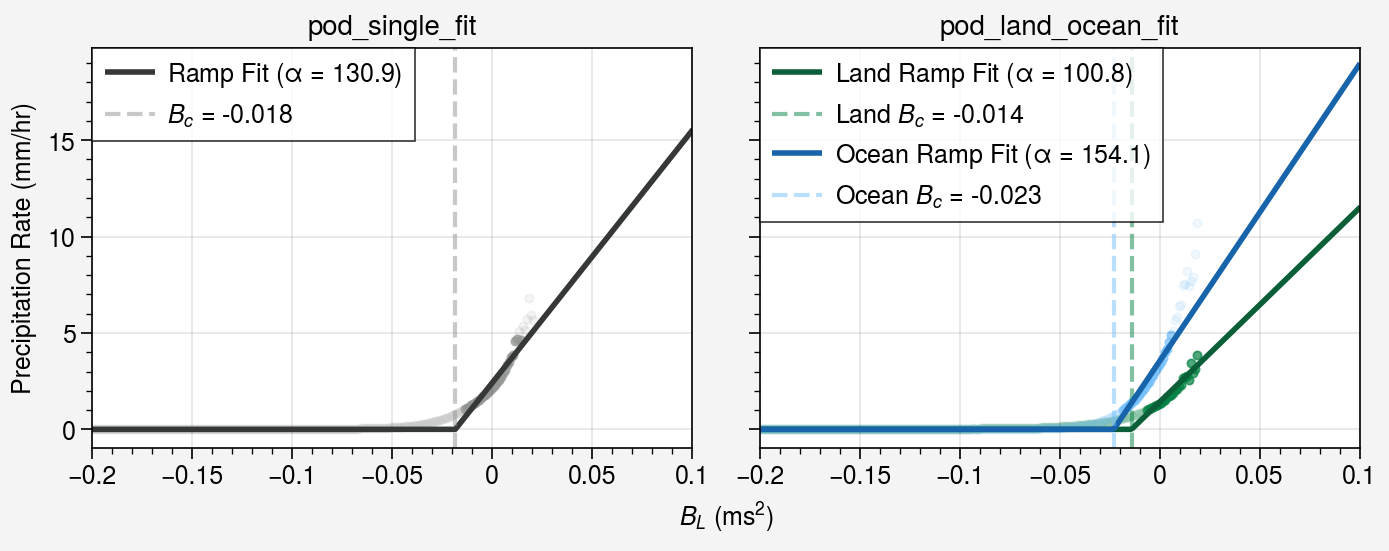

In [27]:
plot_ramp_fits()

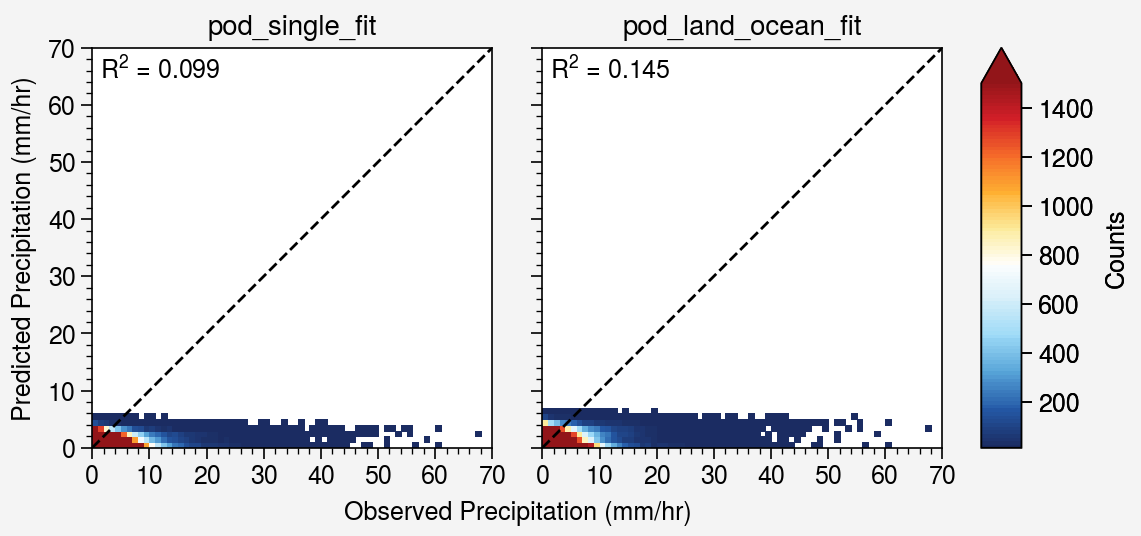

In [28]:
plot_density_panels(results,nrows=1,ncols=2)

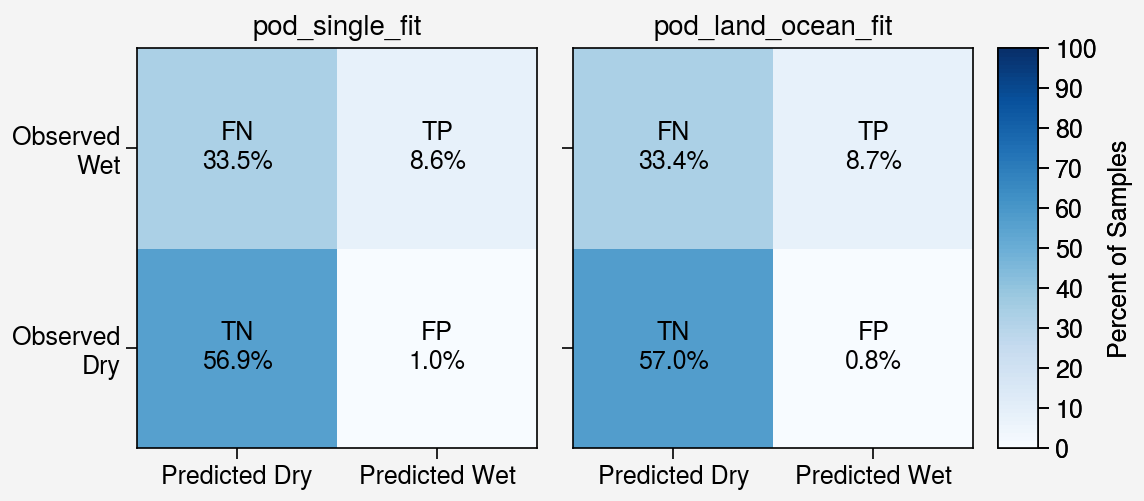

In [29]:
plot_confusion_matrix(results,nrows=1,ncols=2)

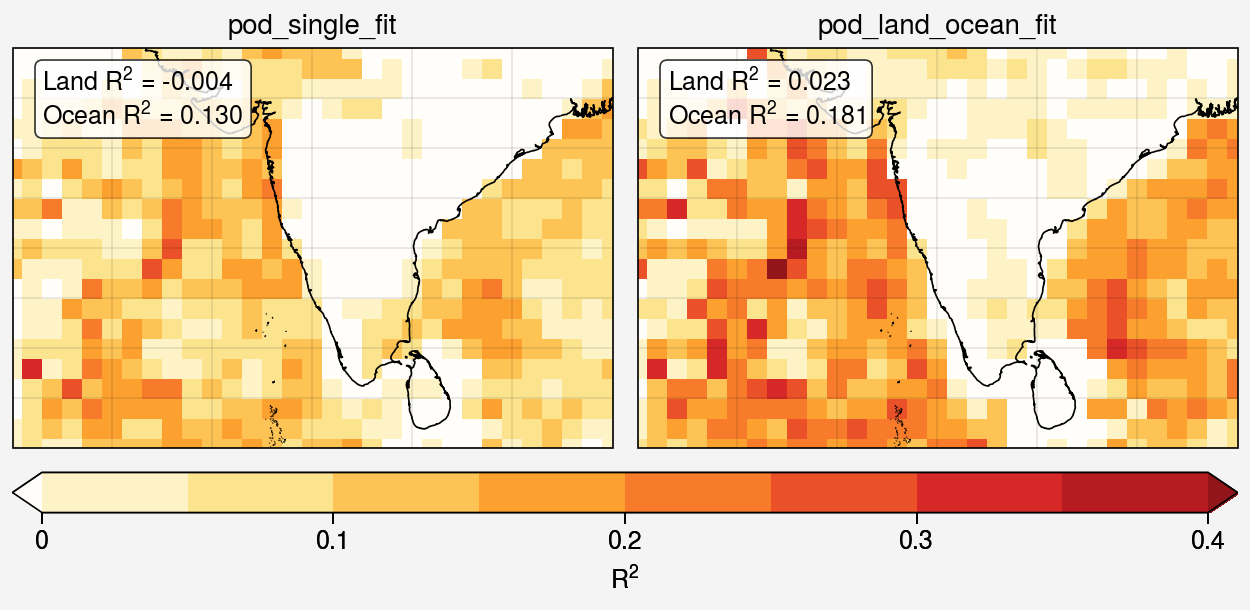

In [30]:
plot_r2_maps(results,nrows=1,ncols=2,landfrac=landfrac)